作业4

In [347]:
import pandas as pd
import tushare as ts    # 导入tushare库
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
pro = ts.pro_api('f6b511d8d4529f19319e1861edadda749e64a5b8573102deec80cfd8')   # 将复制好的token命令复制进api中
plt.rcParams['font.sans-serif'] = ['simhei'] #字体为黑体
plt.rcParams['axes.unicode_minus'] = False #正常显示负号 
from statsmodels.tsa import stattools
import statsmodels.api as sm
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

In [348]:
from scipy import  stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [349]:
#从tushare获取数据
def get_data(year_start,year_end,stock_index,Type="daily"):
    Startday=str(year_start)+'0101'
    Endday=str(year_end)+'1231'
    df=pd.DataFrame()
    if Type=="daily":
        if stock_index=="000300.SH":
            df=pro.index_daily(ts_code=stock_index, start_date=Startday, end_date=Endday, fields='trade_date,open')
        else:
            df = pro.daily(ts_code=stock_index, start_date=Startday, end_date=Endday, fields='trade_date,open')
    elif Type=="monthly":
        if stock_index=="000300.SH":
            df=pro.index_monthly(ts_code=stock_index, start_date=Startday, end_date=Endday, fields='trade_date,open')
        else:
            df=pro.monthly(ts_code=stock_index, start_date=Startday, end_date=Endday, fields='trade_date,open')
    df=df.rename(columns={'open':stock_index})
    return df

In [350]:
#股票指数列表，包含10支股票和1支指数(沪深300)
stock_list=['000001.SZ', '000014.SZ','000027.SZ','000088.SZ', '000096.SZ','000400.SZ','000419.SZ',
 '000423.SZ','000528.SZ','000550.SZ','000300.SH']

In [351]:
#批量获取股票数据
def get_datas(year_start,year_end,stock_list,Type="daily"):
    df=get_data(year_start,year_end,stock_list[0],Type)
    for item in stock_list[1:]:
        df1=get_data(year_start,year_end,item,Type)
        df=pd.merge(df,df1,on="trade_date",how='inner')
    df2=df.iloc[::-1]
    df2.index=range(len(df2))
    return df2

In [352]:
#获取10-19年的月数据
data=get_datas(2010,2019,stock_list,Type="monthly")
data.set_index(["trade_date"], inplace=True)

In [353]:
data

,000001.SZ,000014.SZ,000027.SZ,000088.SZ,000096.SZ,000400.SZ,000419.SZ,000423.SZ,000528.SZ,000550.SZ,000300.SH
trade_date,,,,,,,,,,,
20100129,24.52,15.51,13.77,8.37,7.78,22.76,7.45,26.15,22.00,23.30,3592.470
20100226,21.71,13.00,12.48,8.18,7.26,24.16,8.96,29.50,20.01,19.32,3198.230
20100331,22.89,13.40,12.94,8.27,7.86,26.41,8.84,30.05,22.33,21.75,3290.010
20100430,23.27,13.80,13.20,8.83,8.24,32.30,9.42,28.20,21.86,21.40,3349.880
20100531,20.10,10.73,11.80,7.41,7.90,33.47,9.85,32.50,19.80,22.30,3005.490
...,...,...,...,...,...,...,...,...,...,...,...
20190830,14.06,9.35,5.90,5.43,9.20,8.60,4.53,33.01,6.73,17.26,3819.324
20190930,14.15,9.72,5.90,5.93,9.80,8.46,4.22,31.50,6.20,14.11,3803.689
20191031,15.60,9.40,5.78,5.86,10.01,8.63,4.28,30.48,6.22,16.47,3818.589


In [354]:
#净收益率和连续收益率
data_return=(data/data.shift(1)-1).iloc[1:]
data_logret=np.log(1+data_return)

由于我们的模型涉及超额收益率而非收益率，故将所得数据减去十年期股票平均月收益率$r_0$

In [355]:
r_0=0.0004
data_exlogret=data_logret-r_0

In [356]:
data_exlogret

,000001.SZ,000014.SZ,000027.SZ,000088.SZ,000096.SZ,000400.SZ,000419.SZ,000423.SZ,000528.SZ,000550.SZ,000300.SH
trade_date,,,,,,,,,,,
20100226,-0.122116,-0.176936,-0.098765,-0.023362,-0.069577,0.059294,0.184156,0.120141,-0.095210,-0.187713,-0.116642
20100331,0.052527,0.029905,0.035796,0.010542,0.079007,0.088644,-0.013883,0.018072,0.109299,0.118073,0.027893
20100430,0.016065,0.029014,0.019494,0.065121,0.046814,0.200925,0.063148,-0.063941,-0.021673,-0.016623,0.017634
20100531,-0.146845,-0.252025,-0.112517,-0.175725,-0.042538,0.035182,0.044236,0.141518,-0.099377,0.040796,-0.108884
20100630,-0.142927,-0.032600,-0.125733,-0.101123,-0.244328,-0.003093,-0.107454,0.130358,-0.045334,-0.187216,-0.087322
...,...,...,...,...,...,...,...,...,...,...,...
20190830,0.003163,-0.042291,-0.062818,-0.020455,-0.059489,-0.067841,-0.032976,-0.196959,-0.006326,-0.112631,-0.021132
20190930,0.005981,0.038409,-0.000400,0.087685,0.062779,-0.016813,-0.071287,-0.047223,-0.082426,-0.201908,-0.004502
20191031,0.097156,-0.033876,-0.020949,-0.012275,0.020802,0.019495,0.013718,-0.033317,0.002821,0.154257,0.003510


问题1：每个股票关于指数回归, 回归结果Regression_result中'alpha','beta','R2','t-stat','p-value'分别表示回归的截距的估计，回归系数的估计，R-squared，对截距项估计的t统计量和p值. Resid用于储存每个股票回归的残差

$N$ 种资产超额收益率的线性模型，一元模型
$$
\begin{array}{l}
\overrightarrow{\mathbf{Z}}_{t}=\overrightarrow{\boldsymbol{\alpha}}+\overrightarrow{\boldsymbol{\beta}} z_{m t}+\overrightarrow{\boldsymbol{\varepsilon}}_{\mathbf{t}}, t=1,2, \ldots, T \\
E\left[\overrightarrow{\boldsymbol{\varepsilon}}_{\mathrm{t}}\right]=0 \\
E\left[\vec{\varepsilon}_{\mathrm{t}} \vec{\varepsilon}_{\mathbf{t}}^{\prime}\right]=\boldsymbol{\Sigma} \\
E\left[z_{m t}\right]=\mu_{m}, E\left[\left(z_{m t}-\mu_{m}\right)^{2}\right]=\sigma_{m}^{2} \\
\operatorname{Cov}\left[z_{m t}, \boldsymbol{\varepsilon}_{i \mathbf{t}}\right]=0
\end{array}
$$

In [357]:
Regression_result=pd.DataFrame(columns=stock_list[:-1],index=['alpha','beta','R2','t-stat','p-value'])
Resid=pd.DataFrame(columns=stock_list[:-1])

In [358]:
#沪深300对各个股票exlogret回归
for item in stock_list[:-1]:
    X=np.array(data_exlogret['000300.SH']).reshape(-1, 1)
    Y=np.array(data_exlogret[item]).reshape(-1, 1)
    model0 = LinearRegression()
    model0.fit(X, Y)
    a = model0.intercept_  # 截距估计
    b = model0.coef_  # 回归系数估计
    r_sq = model0.score(X, Y) #R2
    intercepts=Y-X*b #截距项
    resid=(Y-model0.predict(X)).reshape(1,-1)[0]#残差
    Resid[item]=resid
    t_test=stats.ttest_1samp(intercepts, 0) #截距项单样本t检验
    Regression_result.loc['alpha',item]=a[0]
    Regression_result.loc['beta',item]=b[0][0]
    Regression_result.loc['R2',item]=r_sq
    Regression_result.loc['t-stat',item]=t_test.statistic[0]
    Regression_result.loc['p-value',item]=t_test.pvalue[0]

In [359]:
Regression_result

,000001.SZ,000014.SZ,000027.SZ,000088.SZ,000096.SZ,000400.SZ,000419.SZ,000423.SZ,000528.SZ,000550.SZ
alpha,-0.00480199,-0.0057047,-0.00802387,-0.00455456,0.00215815,-0.0081601,-0.00549164,0.00175002,-0.0117207,-0.00494559
beta,1.19292,0.994586,1.03915,0.949548,0.919688,0.736634,0.887415,0.578622,1.37816,0.740525
R2,0.500436,0.270704,0.464205,0.343798,0.324122,0.19127,0.332773,0.193315,0.526174,0.182195
t-stat,-0.622649,-0.540058,-1.11075,-0.536559,0.251141,-0.83257,-0.67541,0.228815,-1.38505,-0.487166
p-value,0.534792,0.590239,0.269077,0.592646,0.80217,0.406875,0.50082,0.819434,0.168814,0.627101


对于模型设定的回归诊断检验，我们检验模型残差是否符合正态分布，使用QQplot的方法

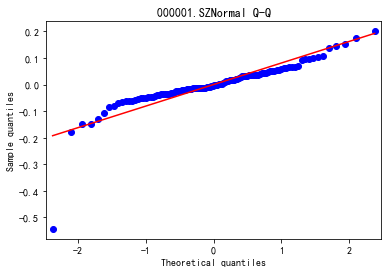

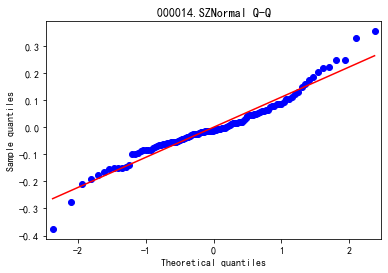

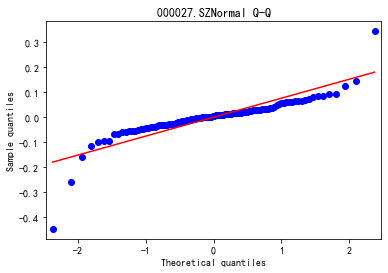

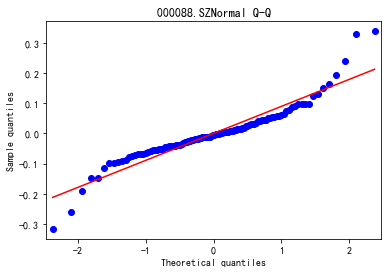

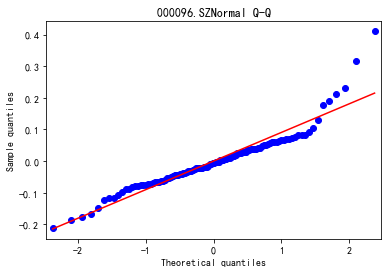

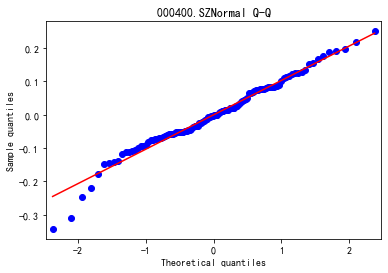

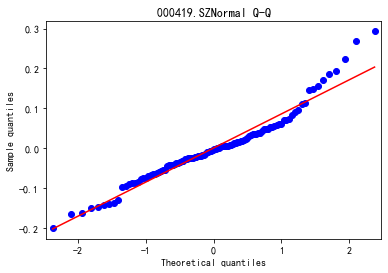

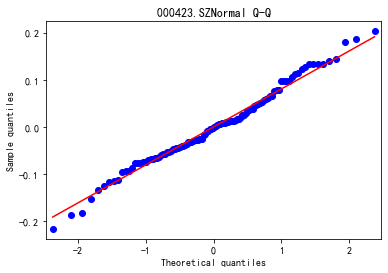

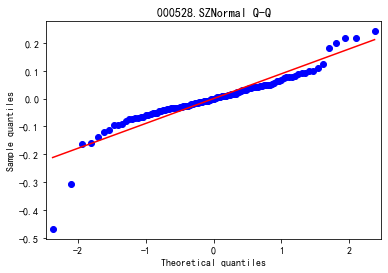

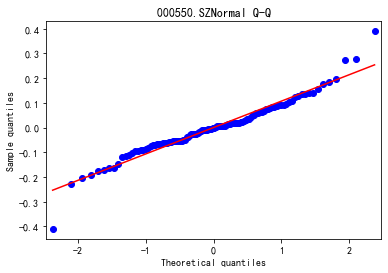

In [360]:
# 残差QQ图：用来描述残差是否符合正态分布
for item in stock_list[:-1]:
    qqplot = sm.qqplot(Resid[item], line='s')
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Sample quantiles')
    plt.title(item+'Normal Q-Q')
    plt.show(qqplot)

问题2.加入等权组合

In [361]:
data_exlogret_new=data_exlogret.copy()
data_exlogret_new["Equal_Weight"]=(data_exlogret.iloc[:,:-1]).mean(axis=1)

In [362]:
Regression_result_new=pd.DataFrame(columns=stock_list[:-1]+["Equal_Weight"],index=['alpha','beta','R2','t-stat','p-value'])
Resid_new=pd.DataFrame(columns=stock_list[:-1]+["Equal_Weight"])

In [363]:
#沪深300对各个股票及等权组合exlogret回归
for item in stock_list[:-1]+["Equal_Weight"]:
    X=np.array(data_exlogret_new['000300.SH']).reshape(-1, 1)
    Y=np.array(data_exlogret_new[item]).reshape(-1, 1)
    model1 = LinearRegression()
    model1.fit(X, Y)
    a = model1.intercept_  # 截距估计
    b = model1.coef_  # 回归系数估计
    r_sq = model1.score(X, Y) #R2
    intercepts=Y-X*b #截距项
    resid=(Y-model1.predict(X)).reshape(1,-1)[0]#残差
    Resid_new[item]=resid
    t_test=stats.ttest_1samp(intercepts, 0) #截距项单样本t检验
    Regression_result_new.loc['alpha',item]=a[0]
    Regression_result_new.loc['beta',item]=b[0][0]
    Regression_result_new.loc['R2',item]=r_sq
    Regression_result_new.loc['t-stat',item]=t_test.statistic[0]
    Regression_result_new.loc['p-value',item]=t_test.pvalue[0]

In [364]:
Regression_result_new

,000001.SZ,000014.SZ,000027.SZ,000088.SZ,000096.SZ,000400.SZ,000419.SZ,000423.SZ,000528.SZ,000550.SZ,Equal_Weight
alpha,-0.00480199,-0.0057047,-0.00802387,-0.00455456,0.00215815,-0.0081601,-0.00549164,0.00175002,-0.0117207,-0.00494559,-0.0049495
beta,1.19292,0.994586,1.03915,0.949548,0.919688,0.736634,0.887415,0.578622,1.37816,0.740525,0.941725
R2,0.500436,0.270704,0.464205,0.343798,0.324122,0.19127,0.332773,0.193315,0.526174,0.182195,0.758577
t-stat,-0.622649,-0.540058,-1.11075,-0.536559,0.251141,-0.83257,-0.67541,0.228815,-1.38505,-0.487166,-1.4398
p-value,0.534792,0.590239,0.269077,0.592646,0.80217,0.406875,0.50082,0.819434,0.168814,0.627101,0.152737


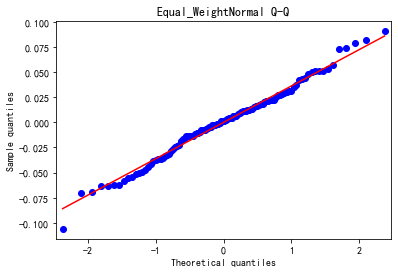

In [365]:
# 残差QQ图：用来描述残差是否符合正态分布
qqplot = sm.qqplot(Resid_new['Equal_Weight'], line='s')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.title('Equal_Weight'+'Normal Q-Q')
plt.show(qqplot)

问题3.计算F检验统计量$J_1$

似然方程的解
$$
\begin{array}{l}
\widehat{\boldsymbol{\alpha}}=\hat{\vec{\mu}}-\hat{\vec{\beta}} \hat{\mu}_{m}, \widehat{\boldsymbol{\beta}}=\frac{\sum_{t=1}^{T}\ \left(\overrightarrow{\mathbf{Z}}_{t}-\hat{\vec{\mu}}\right)\left(z_{m t}-\hat{\mu}_{m}\right)}{\sum_{t=1}^{T}\left(z_{m t}-\hat{\mu}_{m}\right)^{2}} \\
\widehat{\boldsymbol{\Sigma}}=\frac{1}{T} \sum_{t=1}^{T}\left(\overrightarrow{\mathbf{Z}}_{t}-\hat{\vec{\alpha}}-\hat{\vec{\beta}}z_{m t}\right)\left(\overrightarrow{\mathbf{Z}}_{t}-\hat{\vec{\alpha}}-\hat{\vec{\beta}} z_{m t}\right)^{\prime} \\
\hat{\vec{\mu}}=\frac{1}{T} \sum_{t=1}^{T} \mathbf{z}_{t}, \hat{\mu}_{m}=\frac{1}{T} \sum_{t=1}^{T} z_{m t}
\end{array}
$$

直接定义统计量:
$J_{1}=\frac{T-N-1}{N}\left[1+\frac{\hat{\mu}_{m}^{2}}{\hat{\sigma}_{m}^{2}}\right]^{-1} \widehat{\overrightarrow{\boldsymbol{\alpha}}}^{\prime} \widehat{\mathbf{\Sigma}}^{-1} \widehat{\boldsymbol{\alpha}}$


In [369]:
#估计量
N=len(stock_list[:-1])
T=len(data_logret)
alpha_hat=Regression_result.loc['alpha']
beta_hat_hat=Regression_result.loc['beta']
mu_hat=data_exlogret.iloc[:,:-1].mean()
mu_m_hat=data_exlogret.iloc[:,-1].mean()
sigma_m_hat=data_exlogret.iloc[:,-1].std()
Sigma_hat=np.array(Resid.cov())

计算统计量 $J_1$

In [370]:
J_1=(T-N-1)/N*np.power(1+np.power(mu_m_hat/sigma_m_hat,2),-1)*\
np.dot(np.dot (alpha_hat.T, np.linalg.inv(Sigma_hat)),alpha_hat)
J_1

0.5252829761677997

当 $H_{0}: \vec{\alpha}=\overrightarrow{0}$ 成立时, $J_{1} \sim F_{N, T-N-1}$, 以下计算该检验的p值

In [371]:
p_value_Ftest=1-stats.f.cdf(J_1, N, T-N-1)
p_value_Ftest

0.8687437278982977

不拒绝原假设$H_{0}: \overrightarrow{\boldsymbol{\alpha}}=\overrightarrow{0}$